In this notebook diffrent parameters are tested, inorder to find a optimal choice of parameters for an LSTM network with respect to validation preformence. The traing data contains samples form skier 1, and 3, wheresd the validation is done on skier 2.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import math
import keras
from random import shuffle
from keras.models import Sequential, Model
from keras.layers import Dense,Bidirectional
from keras.layers import LSTM, Flatten, Input
from keras.layers import BatchNormalization
from keras.layers import TimeDistributed, Conv1D, Conv2D, MaxPooling1D, GlobalMaxPooling1D,Dropout
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.optimizers import Adam

Using TensorFlow backend.
/Users/mariekorneliusson/anaconda3/envs/dml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
path = os.path.normpath('/Users/mariekorneliusson/documents/AiSports/Strike_Data_As_Np')

In [3]:
X_First = np.load(path + '/' + 'X_First_Skier.npy')
Y_First = np.load(path + '/' + 'Y_First_Skier.npy')
feature_list_First = []
with open(path + "/keys_First_Skier.txt", "r") as f:
      for line in f:
        feature_list_First.append(line.strip('\n'))

In [4]:
X_Second = np.load(path + '/' + 'X_Second_Skier.npy')
Y_Second = np.load(path + '/' + 'Y_Second_Skier.npy')
feature_list_Second = []
with open(path + "/keys_Second_Skier.txt", "r") as f:
      for line in f:
        feature_list_Second.append(line.strip('\n'))

In [5]:
X_Third = np.load(path + '/' + 'X_Third_Skier.npy')
Y_Third = np.load(path + '/' + 'Y_Third_Skier.npy')
feature_list_Third = []
with open(path + "/keys_Third_Skier.txt", "r") as f:
      for line in f:
        feature_list_Third.append(line.strip('\n'))

In [6]:
feature_Dict = {i:feature_list_Second[i] for i in range(len(feature_list_Second)-1)}
print(len(feature_Dict))

17


In [7]:
print(X_First.shape)
print(X_Second.shape)
print(X_Third.shape)
print(Y_First.shape)
print(Y_Second.shape)
print(Y_Third.shape)

(452, 140, 22)
(382, 140, 18)
(844, 140, 22)
(452, 4)
(382, 4)
(844, 4)


In [8]:
dim_X = len(feature_Dict)
time_step = 140
nbr_of_classes = 4
X = np.concatenate((X_First, X_Third), axis=0)[:,:,:dim_X]
Y= np.concatenate((Y_First, Y_Third), axis=0)
X=X[:700,:,:dim_X]
Y=Y[:700,:]
X_Val = X[700:,:,:dim_X]
Y_Val = Y[700:,:]
#X_Val = X_Second[:175,:,:dim_X]
#Y_Val = Y_Second[:175,:]
X_Test = X_Second
Y_Test = Y_Second

In [10]:
print(X.shape)
print(Y.shape)
print(X_Val.shape)
print(Y_Val.shape)
print(X_Test.shape)
print(Y_Test.shape)

(700, 140, 17)
(700, 4)
(0, 140, 17)
(0, 4)
(382, 140, 18)
(382, 4)


In [11]:
def get_strike(strike,strike_l,pad):
    
    for j in range(strike_l-3):
        if strike[j,1] == strike[j+1,1] == strike[j+2,1] == pad:
            plot_strike = strike[0:j-1,1]
            time_strike = strike[0:j-1,0]
            break
        elif strike[strike_l-2,0] > 0:
            plot_strike = strike[:,1]
            time_strike = strike[:,0]
            break
    
    return plot_strike,time_strike

In [12]:
def change_time_axis_for_plot(X,delta_t):
    
    nbr_of_samples = X.shape[0]
    t = 0
    for i in range(nbr_of_samples):
        for j in range(140):
            X[i,j,0] = t*delta_t
            t = t + 1
    
    return X

In [40]:
def plot_skiedata(true_Y,X,figure):

    nbr_of_classes = 4
    colorDict = {0:'r',1:'fuchsia',2:'deeppink',3:'orange'}
    nameDict = {0:'Gear 2',1:'Gear 3',2:'Gear 4',3:'Double','Gear 2':0,'Gear 3':1,'Gear 4':2,'Double':3}
    nbr_of_test = X.shape[0]
    strike_l = X.shape[1]
    pad = 0

    for c in range(nbr_of_classes):
        true_c = np.where(true_Y == c)[0]
        strike_true = []
        strike_pred = []
        time_true = []
        time_pred = []
        for i in range(true_c.shape[0]):
            strike = X[true_c[i],:,:]
            t_strike,t_time = get_strike(strike,strike_l,pad)
            strike_true.extend(t_strike)
            time_true.extend(t_time)

        plt.figure(figure,figsize=(15, 4))
        plt.title('True gear')
        plt.scatter(time_true,strike_true,label = 'True class: ' + nameDict[c],color =  colorDict[c], alpha = 1)
        plt.legend()
        #plt.axis([280, 320, 0, 400])
    figure = figure + 1
    return figure

In [13]:
delta_t = 0.02
X = change_time_axis_for_plot(X,delta_t)
X_Test = change_time_axis_for_plot(X_Test,delta_t)

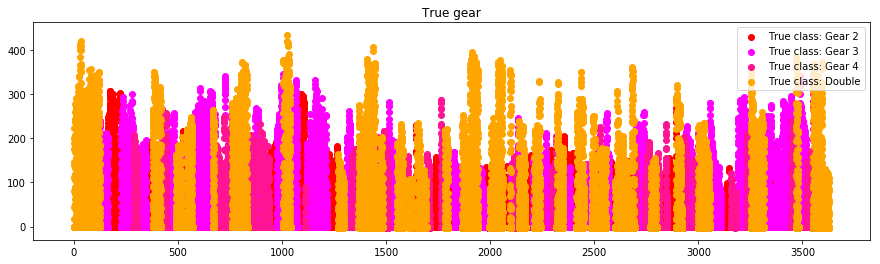

In [26]:
true_Y = np.argmax(Y,axis = 1)
figure = plot_skiedata(true_Y,X,0)

In [14]:
def LSTM_Two_Dense_26():
    
    sequence_input = Input(shape=(time_step,dim_X-1))
    print(sequence_input.shape)
    x = LSTM(26,return_sequences=True)(sequence_input)
    print(x.shape)
    x = Dense(X.shape[1], activation='relu')(x)
    print(x.shape)
    x = Flatten()(x)
    print(x.shape)
    preds = Dense(nbr_of_classes, activation='softmax')(x)
    model = Model(sequence_input, preds)
    model.compile(Adam(lr=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

def LSTM_Two_Dense_64():
    
    sequence_input = Input(shape=(time_step,dim_X-1))
    x = LSTM(64,return_sequences=True)(sequence_input)
    x = Dense(X.shape[1], activation='relu')(x)
    x = Flatten()(x)
    preds = Dense(nbr_of_classes, activation='softmax')(x)
    model = Model(sequence_input, preds)
    model.compile(Adam(lr=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

def LSTM_Two_Dense_126():
    
    sequence_input = Input(shape=(time_step,dim_X-1))
    x = LSTM(126,return_sequences=True)(sequence_input)
    x = Dense(X.shape[1], activation='relu')(x)
    x = Flatten()(x)
    preds = Dense(nbr_of_classes, activation='softmax')(x)
    model = Model(sequence_input, preds)
    model.compile(Adam(lr=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

def LSTM_Two_Dense_64_Drop():
    
    sequence_input = Input(shape=(time_step,dim_X-1))
    x = LSTM(64,return_sequences=True, recurrent_dropout = 0.2)(sequence_input)
    x = Dense(X.shape[1], activation='relu')(x)
    x = Flatten()(x)
    preds = Dense(nbr_of_classes, activation='softmax')(x)
    model = Model(sequence_input, preds)
    model.compile(Adam(lr=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

def LSTM_Two_Dense_126_Drop():
    
    sequence_input = Input(shape=(time_step,dim_X-1))
    x = LSTM(126,return_sequences=True, recurrent_dropout = 0.2)(sequence_input)
    x = Dense(X.shape[1], activation='relu')(x)
    x = Flatten()(x)
    preds = Dense(nbr_of_classes, activation='softmax')(x)
    model = Model(sequence_input, preds)
    model.compile(Adam(lr=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model
def LSTM_Two_Dense_126_Drop_04():
    
    sequence_input = Input(shape=(time_step,dim_X-1))
    x = LSTM(126,return_sequences=True, recurrent_dropout = 0.4)(sequence_input)
    x = Dense(X.shape[1], activation='relu')(x)
    x = Flatten()(x)
    preds = Dense(nbr_of_classes, activation='softmax')(x)
    model = Model(sequence_input, preds)
    model.compile(Adam(lr=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [15]:
model = LSTM_Two_Dense_126()
eS = EarlyStopping(monitor='acc', min_delta=0.00001, patience=5)
history = model.fit(X[:,:,1:], Y, epochs=3, batch_size=1, validation_data=(X_Val[:,:,1:],Y_Val),shuffle = True,callbacks = [eS])

Train on 700 samples, validate on 0 samples
Epoch 1/3
700/700 [==============================] - 141s 201ms/step - loss: 0.5423 - acc: 0.7914
Epoch 2/3
700/700 [==============================] - 144s 205ms/step - loss: 0.1851 - acc: 0.9400
Epoch 3/3
700/700 [==============================] - 142s 203ms/step - loss: 0.0763 - acc: 0.9814


In [34]:
model = LSTM_Two_Dense_126_Drop()
eS = EarlyStopping(monitor='acc', min_delta=0.00001, patience=5)
history = model.fit(X[:,:,1:], Y, epochs=3, batch_size=1, validation_data=(X_Val[:,:,1:],Y_Val),shuffle = True,callbacks = [eS])

Train on 1296 samples, validate on 382 samples
Epoch 1/3
1296/1296 [==============================] - 305s 236ms/step - loss: 0.3895 - acc: 0.8457 - val_loss: 0.9857 - val_acc: 0.7304
Epoch 2/3
1296/1296 [==============================] - 304s 234ms/step - loss: 0.1306 - acc: 0.9560 - val_loss: 0.9759 - val_acc: 0.7539
Epoch 3/3
1296/1296 [==============================] - 302s 233ms/step - loss: 0.0747 - acc: 0.9745 - val_loss: 0.9942 - val_acc: 0.7199


In [35]:
model = LSTM_Two_Dense_64_Drop()
eS = EarlyStopping(monitor='acc', min_delta=0.00001, patience=5)
history = model.fit(X[:,:,1:], Y, epochs=3, batch_size=1, validation_data=(X_Val[:,:,1:],Y_Val),shuffle = True,callbacks = [eS])

Train on 1296 samples, validate on 382 samples
Epoch 1/3
1296/1296 [==============================] - 299s 230ms/step - loss: 0.4288 - acc: 0.8372 - val_loss: 0.8809 - val_acc: 0.6257
Epoch 2/3
1296/1296 [==============================] - 295s 228ms/step - loss: 0.1611 - acc: 0.9444 - val_loss: 1.0344 - val_acc: 0.6152
Epoch 3/3
1296/1296 [==============================] - 296s 229ms/step - loss: 0.0952 - acc: 0.9684 - val_loss: 1.0553 - val_acc: 0.6361


In [16]:
model = LSTM_Two_Dense_126_Drop()
mCp = ModelCheckpoint('LSTM_1_3_Uppdate.h5', monitor='val_loss', save_best_only=True)
history = model.fit(X[:,:,1:], Y, epochs=5, batch_size=1, validation_data=(X_Val[:,:,1:],Y_Val),shuffle = True,callbacks = [mCp])

Train on 700 samples, validate on 0 samples
Epoch 1/5
700/700 [==============================] - 167s 239ms/step - loss: 0.5552 - acc: 0.7771
Epoch 2/5


/Users/mariekorneliusson/anaconda3/envs/dml/lib/python3.6/site-packages/keras/callbacks.py:432: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


700/700 [==============================] - 166s 236ms/step - loss: 0.1851 - acc: 0.9486
Epoch 3/5
700/700 [==============================] - 161s 230ms/step - loss: 0.0935 - acc: 0.9757
Epoch 4/5
700/700 [==============================] - 160s 229ms/step - loss: 0.0485 - acc: 0.9914
Epoch 5/5
700/700 [==============================] - 158s 226ms/step - loss: 0.0247 - acc: 0.9971


In [35]:
from keras.models import load_model
model.save('LSTM_1_3_Uppdate.h5')

In [31]:
LSTM_Two_Dense_126_Drop_04()
mCp = ModelCheckpoint('LSTM_1_3_New.h5', monitor='val_loss', save_best_only=True)
history  = model.fit(X[:,:,1:], Y, epochs=5, batch_size=1, validation_data=(X_Val[:,:,1:],Y_Val),shuffle = True,callbacks = [mCp])

Train on 700 samples, validate on 0 samples
Epoch 1/5
700/700 [==============================] - 160s 229ms/step - loss: 0.0095 - acc: 0.9986
Epoch 2/5


/Users/mariekorneliusson/anaconda3/envs/dml/lib/python3.6/site-packages/keras/callbacks.py:432: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


700/700 [==============================] - 159s 227ms/step - loss: 0.0033 - acc: 0.9986
Epoch 3/5
700/700 [==============================] - 161s 230ms/step - loss: 0.0019 - acc: 0.9986
Epoch 4/5
700/700 [==============================] - 159s 227ms/step - loss: 0.0012 - acc: 0.9986
Epoch 5/5
700/700 [==============================] - 162s 231ms/step - loss: 0.0011 - acc: 0.9986


In [36]:
from keras.models import load_model
model.save('LSTM_1_3_New.h5')

In [37]:
from keras.models import load_model
model = load_model('LSTM_1_3_New.h5')
predY = model.predict(X_Test[:,:,1:dim_X])
print(predY.shape)
pred_Y = np.argmax(predY,axis = 1)
true_Y = np.argmax(Y_Test,axis = 1)
acc = accuracy_score(true_Y,pred_Y)
print("Accuracy: %.2f" % acc)

(382, 4)
Accuracy: 0.81
